In [1]:
import time
import requests
import pandas as pd
import numpy as np
import threading

In [2]:
api_key = '2CCS30TFYFGYBXKB'
top_customers = {'TSMC':['AAPL', 'AMD', 'QCOM', 'AVGO', 'NVDA', 'SONY', 'MRVL', 'STM', 'ADI', 'INTC'],
                'SMIC':['QCOM', 'AVGO', 'TXN'],
                'UMC':['QCOM', 'AMD'],
                'GF':['QCOM', 'NXPI', 'QRVO', 'CRUS', 'AMD', 'SWKS', 'AVGO']
            }
call_count = 0

In [3]:
def get_revenue(ticker):
    global call_count
    if call_count == 5:
        time.sleep(60)
        call_count = 0
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={api_key}'
    call_count += 1
    r = requests.get(url)
    json_data = r.json()
    if json_data:
        quarter_data = pd.DataFrame.from_dict(json_data['quarterlyReports'])
        revenue_df = quarter_data[["fiscalDateEnding", "reportedCurrency", "totalRevenue"]]
        revenue_df.insert(0, 'quarter', [int(s.split("-")[1]) // 3 for s in revenue_df["fiscalDateEnding"]])
        revenue_df.insert(0, 'year', [int(s.split("-")[0]) for s in revenue_df["fiscalDateEnding"]])
        revenue_df.drop(["fiscalDateEnding"], axis=1, inplace=True)
        if min(revenue_df['quarter']) == 0:
            revenue_df['quarter'] = [q + 1 for q in revenue_df['quarter']]
        return revenue_df
    return pd.DataFrame()

In [8]:
UMC = get_revenue('UMC')

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
AAPL = get_revenue('AAPL')

In [24]:
QCOM = get_revenue('QCOM')

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
UMC #Someone probably converted 2017Q2 and 2018Q2 to USD

,year,quarter,reportedCurrency,totalRevenue
0,2021,4,TWD,59099588000
1,2021,3,TWD,55906677000
2,2021,2,TWD,50907741000
3,2021,1,TWD,47097012000
4,2020,4,TWD,45296353000
5,2020,3,TWD,44870454000
6,2020,2,TWD,44386260000
7,2020,1,TWD,42267847000
8,2019,4,TWD,41849058000
9,2019,3,TWD,37738440000


In [31]:
# Use the converter class here, I was just lazy and brought the numbers over directly
UMC.at[14, 'totalRevenue'] = float(UMC.at[14, 'totalRevenue']) * 29.623
UMC.at[18, 'totalRevenue'] = float(UMC.at[18, 'totalRevenue']) * 30.157

In [46]:
# Reverse the df
UMC = UMC.iloc[::-1]
AAPL = AAPL.iloc[::-1]
QCOM = QCOM.iloc[::-1]

# Difference the data
UMC["revChange"] = pd.to_numeric(UMC.totalRevenue).diff()
UMC["pctRevChange"] = pd.to_numeric(UMC.totalRevenue).pct_change()
AAPL["revChange"] = pd.to_numeric(AAPL.totalRevenue).diff()
AAPL["pctRevChange"] = pd.to_numeric(AAPL.totalRevenue).pct_change()
QCOM["revChange"] = pd.to_numeric(QCOM.totalRevenue).diff()
QCOM["pctRevChange"] = pd.to_numeric(QCOM.totalRevenue).pct_change()

In [55]:
QCOM.head()

,year,quarter,reportedCurrency,totalRevenue,revChange,pctRevChange
19,2017,1,USD,5016000000,NaN,NaN
18,2017,2,USD,5356000000,340000000.0,0.067783
17,2017,3,USD,5888000000,532000000.0,0.099328
16,2017,4,USD,6035000000,147000000.0,0.024966
15,2018,1,USD,5220000000,-815000000.0,-0.135046


In [56]:
UMC.head()

,year,quarter,reportedCurrency,totalRevenue,revChange,pctRevChange
20,2016,4,TWD,38305939000,NaN,NaN
19,2017,1,TWD,37417950000,-8.879890e+08,-0.023181
18,2017,2,TWD,37262351084.0,-1.555989e+08,-0.004158
17,2017,3,TWD,37698201000,4.358499e+08,0.011697
16,2017,4,TWD,36630674000,-1.067527e+09,-0.028318


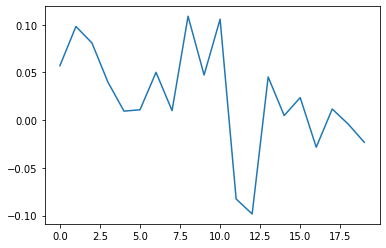

In [49]:
UMC.pctRevChange.plot()

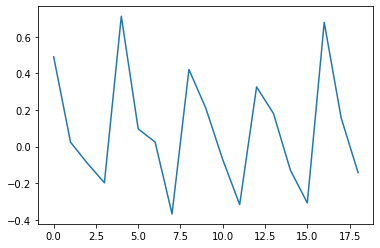

In [50]:
AAPL.pctRevChange.plot()

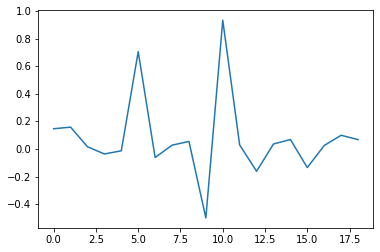

In [51]:
QCOM.pctRevChange.plot()

In [65]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [57]:
x = QCOM.pctRevChange[1:].to_numpy().reshape(-1,1)
y = UMC.pctRevChange[2:].to_numpy()

In [61]:
model = LinearRegression()
reg = model.fit(x,y)

In [59]:
r_sq = model.score(x, y)

In [62]:
reg.predict(x)

array([ 0.02536762,  0.02699925,  0.02315295,  0.01487648,  0.02539905,
        0.02372578,  0.01348261,  0.02335713,  0.07017   , -0.00401926,
        0.02468741,  0.02327772,  0.01865859,  0.05836343,  0.02117368,
        0.0199773 ,  0.02267641,  0.03005019,  0.02944626])

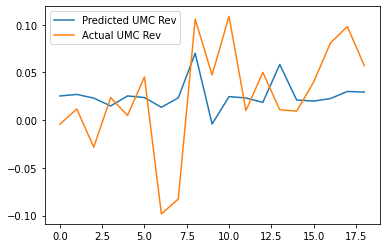

In [68]:
plt.plot(list(range(len(x))), reg.predict(x), label = 'Predicted UMC Rev')
plt.plot(list(range(len(x))), y, label = 'Actual UMC Rev')
plt.legend()
plt.show()